In [2]:
%load_ext pytriqs.magic
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [43]:
%%triqs -u gf
#include <triqs/gfs.hpp>
#include <triqs/gfs/bz.hpp>
#include <triqs/gfs/m_tail.hpp>

namespace h5 = triqs::h5;
using namespace triqs::gfs;
using namespace triqs::clef;
using namespace triqs::arrays;
using namespace triqs::lattice;
using triqs::utility::mindex;

gf<retime, matrix_valued> f(double beta, int x, double mu) {

  auto bz = brillouin_zone{bravais_lattice{make_unit_matrix<double>(2)}};

  int n_freq = 100;
  double t_min=-10, t_max = 10;

  int n_times = n_freq * 2 + 1;
  int L = 50;
  int n_bz = L;

  auto nf = [](double beta, auto eps_k) { return 1.0/(1.0+exp(beta*eps_k)); };
  auto mnf = [](double beta, auto eps_k) { return 1.0-1.0/(1.0+exp(beta*eps_k)); };
  auto make_gxt = [&](auto func) {
    auto gxt = gf<cartesian_product<cyclic_lattice, retime>, matrix_valued, no_tail>{ {{L,L}, {t_min, t_max, n_times}}, {1, 1}};
    auto gkt = gf<cartesian_product<brillouin_zone, retime>, matrix_valued, no_tail>{ {{bz, n_bz}, {t_min, t_max, n_times}}, {1, 1}};
    
    placeholder<0> k_;
    placeholder<1> t_;

    auto eps_k = -2 * (cos(k_(0)) + cos(k_(1))) - mu;
    gkt(k_, t_) << exp(- 1_j * eps_k * t_) * func(beta,eps_k);
    auto gx_t = curry<1>(gxt);
    auto gk_t = curry<1>(gkt);
    gx_t[t_] << inverse_fourier(gk_t[t_]);
    return gxt;
  };

  auto g_lesser = make_gxt(nf);
  auto g_greater = make_gxt(mnf);
  auto identity = [](double, auto){return 1;};
  auto g_T = make_gxt(identity);

  gf<retime> gr{{t_min, t_max, n_times}, {1, 1}};
  make_gf_view_without_tail(gr) = partial_eval<0>(g_lesser, mindex(x,0,0));

  //std::cout << gxt(triqs::utility::mini_vector<long, 3>{0,0,0},0.0)<<std::endl;

  return gr;

}


Comparison in time
==================

/usr/local/lib/python2.7/dist-packages/ipython-3.1.0-py2.7.egg/IPython/kernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide


(-0.05, 0.55)

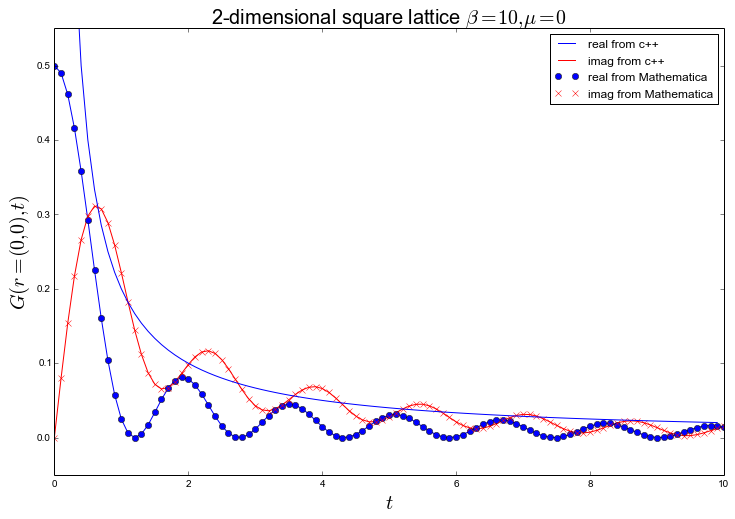

In [44]:
from pytriqs.plot.mpl_interface import *
oplot(f(10.,0,0).real, '-b', label='real from c++')
oplot(f(10.,0,0).imag, '-r', label='imag from c++')
plot(loadtxt("g_mesh"), loadtxt("g_real"), 'bo', label='real from Mathematica')
plot(loadtxt("g_mesh"), loadtxt("g_imag"), 'rx', label='imag from Mathematica')
plot(arange(0,10,0.1), 0.2/arange(0,10,0.1))

plt.title(r"2-dimensional square lattice $\beta=10, \mu = 0$", fontsize=20)
legend()
plt.xlabel("$t$",fontsize=20)
plt.ylabel("$G(r=(0,0),t)$",fontsize=20)
plt.xlim(0,10)
plt.ylim(-0.05,0.55)

(-0.15, 0.25)

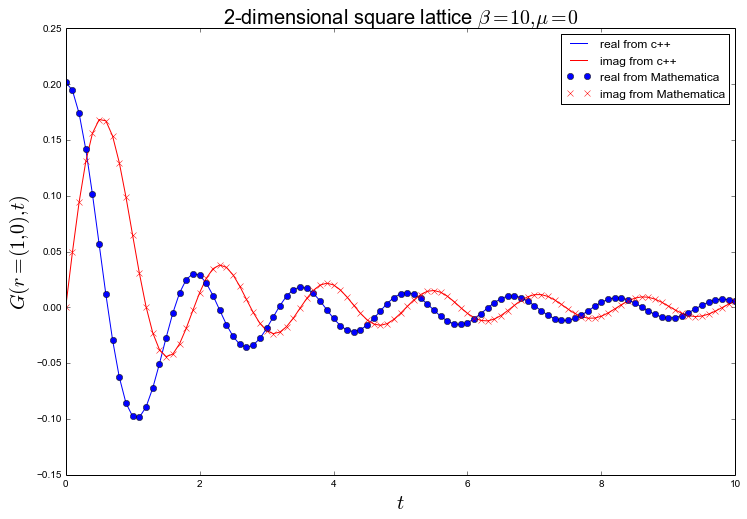

In [45]:
from pytriqs.plot.mpl_interface import *
oplot(f(10.,1,0).real, '-b', label='real from c++')
oplot(f(10.,1,0).imag, '-r', label='imag from c++')
plot(loadtxt("g2_mesh"), loadtxt("g2_real"), 'bo', label='real from Mathematica')
plot(loadtxt("g2_mesh"), loadtxt("g2_imag"), 'rx', label='imag from Mathematica')

plt.title(r"2-dimensional square lattice $\beta=10,\mu=0$", fontsize=20)
legend()
plt.xlabel("$t$",fontsize=20)
plt.ylabel("$G(r=(1,0),t)$",fontsize=20)
plt.xlim(0,10)
plt.ylim(-0.15,0.25)

(-0.15, 0.25)

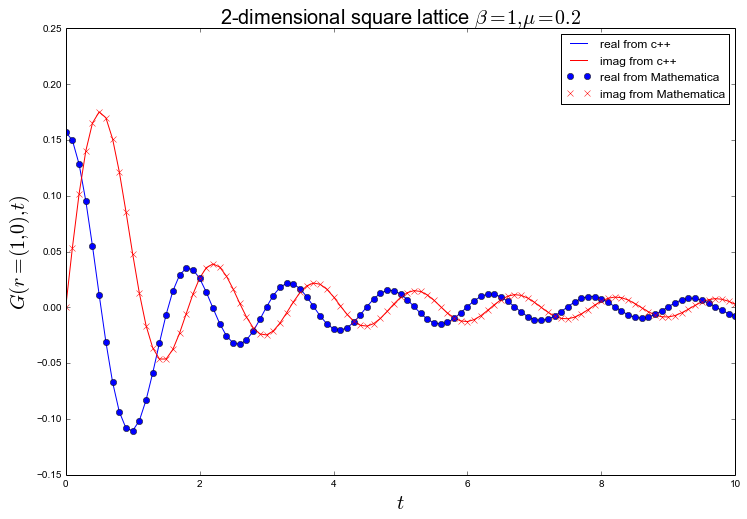

In [48]:
from pytriqs.plot.mpl_interface import *
oplot(f(1.,1,0.2).real, '-b', label='real from c++')
oplot(f(1.,1,0.2).imag, '-r', label='imag from c++')
plot(loadtxt("g3_mesh"), loadtxt("g3_real"), 'bo', label='real from Mathematica')
plot(loadtxt("g3_mesh"), loadtxt("g3_imag"), 'rx', label='imag from Mathematica')

plt.title(r"2-dimensional square lattice $\beta=1,\mu=0.2$", fontsize=20)
legend()
plt.xlabel("$t$",fontsize=20)
plt.ylabel("$G(r=(1,0),t)$",fontsize=20)
plt.xlim(0,10)
plt.ylim(-0.15,0.25)

(-0.15, 0.25)

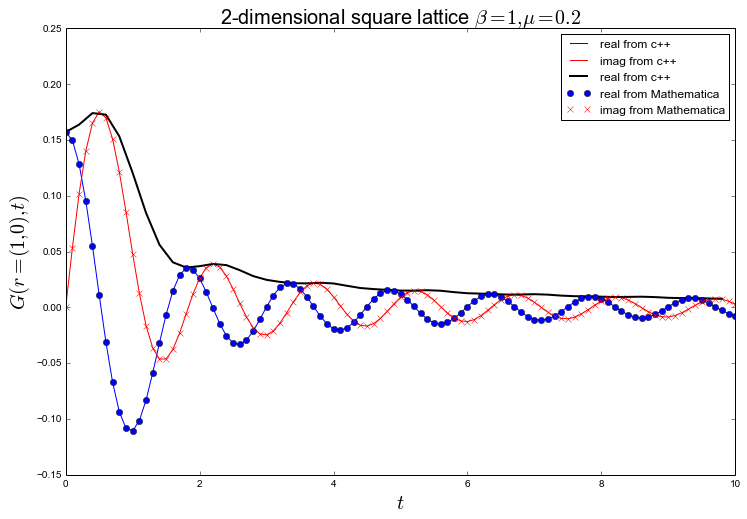

In [6]:
from pytriqs.plot.mpl_interface import *
#print abs(f(1.,1,0.2)(1.0)[0,0])

ft = f(1.,1,0.2)

oplot(ft.real, '-b', label='real from c++')
oplot(ft.imag, '-r', label='imag from c++')
oplot(lambda x: abs(ft(x)[0,0]), '-k', label='real from c++', lw=2)

plot(loadtxt("g3_mesh"), loadtxt("g3_real"), 'bo', label='real from Mathematica')
plot(loadtxt("g3_mesh"), loadtxt("g3_imag"), 'rx', label='imag from Mathematica')

plt.title(r"2-dimensional square lattice $\beta=1,\mu=0.2$", fontsize=20)
legend()
plt.xlabel("$t$",fontsize=20)
plt.ylabel("$G(r=(1,0),t)$",fontsize=20)
plt.xlim(0,10)
plt.ylim(-0.15,0.25)

Comparison along x
==========

In [164]:
%%triqs -u gf
#include <triqs/gfs.hpp>
#include <triqs/gfs/bz.hpp>
#include <triqs/gfs/m_tail.hpp>

namespace h5 = triqs::h5;
using namespace triqs::gfs;
using namespace triqs::clef;
using namespace triqs::arrays;
using namespace triqs::lattice;

array<std::complex<double>,3> fx(double beta, int t, double mu) {

  auto bz = brillouin_zone{bravais_lattice{make_unit_matrix<double>(2)}};

  int n_freq = 100;
  double t_min=-10, t_max = 10;

  int n_times = n_freq * 2 + 1;
  int L = 100;
  int n_bz = L;

  auto nf = [](double beta, auto eps_k) { return 1.0/(1.0+exp(beta*eps_k)); };
  //auto mnf = [](double beta, auto eps_k) { return 1.0-1.0/(1.0+exp(beta*eps_k)); };
  auto make_gxt = [&](auto func) {
    auto gxt = gf<cartesian_product<cyclic_lattice, retime>, matrix_valued, no_tail>{ {{L,L}, {t_min, t_max, n_times}}, {1, 1}};
    auto gkt = gf<cartesian_product<brillouin_zone, retime>, matrix_valued, no_tail>{ {{bz, n_bz}, {t_min, t_max, n_times}}, {1, 1}};
    
    placeholder<0> k_;
    placeholder<1> t_;

    auto eps_k = -2 * (cos(k_(0)) + cos(k_(1))) - mu;
    gkt(k_, t_) << exp(- 1_j * eps_k * t_) * func(beta,eps_k);
    auto gx_t = curry<1>(gxt);
    auto gk_t = curry<1>(gkt);
    gx_t[t_] << inverse_fourier(gk_t[t_]);
    return gxt;
  };

  auto g_lesser = make_gxt(nf);
  return partial_eval<1>(g_lesser, t).data();

}


In [165]:
Gx = fx(10,200,0.0)

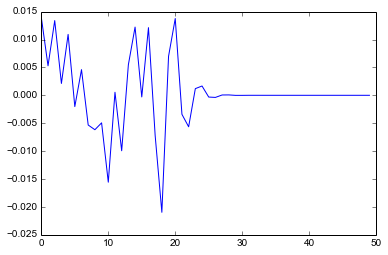

In [166]:
N = 50
plot(arange(0,N), Gx[0:N,0,0].real, '-b')
#plot(arange(0,N), Gx[0:N,0,0].imag, '-x')
#plot(loadtxt("gx_mesh"), loadtxt("gx_real"), 'ro', label='real from Mathematica')
#plot(loadtxt("gx_mesh"), loadtxt("gx_imag"), 'rx', label='imag from Mathematica')
#plt.xlim(0,10)

2d
==

In [97]:
%%triqs -u gf
#include <triqs/gfs.hpp>
#include <triqs/gfs/bz.hpp>
#include <triqs/gfs/m_tail.hpp>

namespace h5 = triqs::h5;
using namespace triqs::gfs;
using namespace triqs::clef;
using namespace triqs::arrays;
using namespace triqs::lattice;

array<std::complex<double>,4> g_array(double beta, double mu) {

  auto bz = brillouin_zone{bravais_lattice{make_unit_matrix<double>(2)}};

  int n_freq = 100;
  double t_min=-10, t_max = 10;

  int n_times = n_freq * 2 + 1;
  int L = 100;
  int n_bz = L;

  auto nf = [](double beta, auto eps_k) { return 1.0/(1.0+exp(beta*eps_k)); };
  //auto mnf = [](double beta, auto eps_k) { return 1.0-1.0/(1.0+exp(beta*eps_k)); };
  auto make_gxt = [&](auto func) {
    auto gxt = gf<cartesian_product<cyclic_lattice, retime>, matrix_valued, no_tail>{ {{L,L}, {t_min, t_max, n_times}}, {1, 1}};
    auto gkt = gf<cartesian_product<brillouin_zone, retime>, matrix_valued, no_tail>{ {{bz, n_bz}, {t_min, t_max, n_times}}, {1, 1}};
    
    placeholder<0> k_;
    placeholder<1> t_;

    auto eps_k = -2 * (cos(k_(0)) + cos(k_(1))) - mu;
    gkt(k_, t_) << exp(- 1_j * eps_k * t_) * func(beta,eps_k);
    auto gx_t = curry<1>(gxt);
    auto gk_t = curry<1>(gkt);
    gx_t[t_] << inverse_fourier(gk_t[t_]);
    return gxt;
  };

  auto g_lesser = make_gxt(nf);
  return g_lesser.data();

            
}


In [98]:
A = g_array(10.,0.)

In [99]:
TwoD = A[:,:,0,0]

<matplotlib.colorbar.Colorbar instance at 0x7f22fa093368>

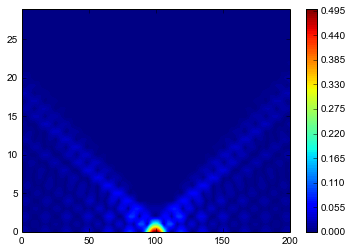

In [102]:
contourf(range(201), range(0,30), abs(TwoD.real[0:30,0:201]), 100)
colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7fd8d61df4d0>

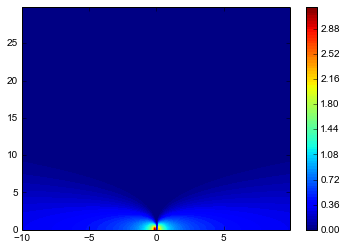

In [145]:
tr = arange(-10,10,0.1)
xr = arange(0,30,0.1)
Z = zeros([len(xr),len(tr)])
for j,t in enumerate(tr):
    for i,x in enumerate(xr):
        if abs(t)>1e-1: Z[i,j] = (1./sqrt(abs(t)))*exp(-x**2/(4*abs(t)))
contourf(tr, xr, Z, 100)
colorbar()

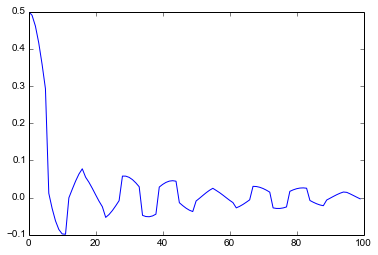

In [151]:
plot(range(100), [TwoD.real[0.18*i,100+i] for i in range(100)])


<matplotlib.colorbar.Colorbar instance at 0x7fd8d33cf7a0>

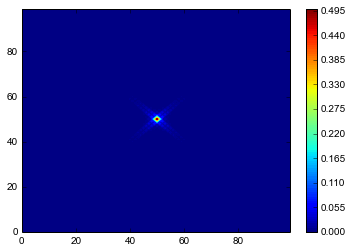

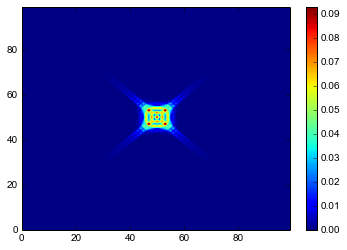

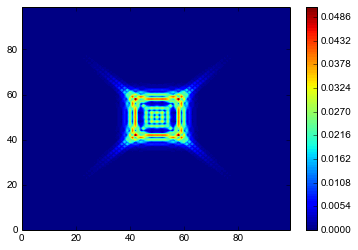

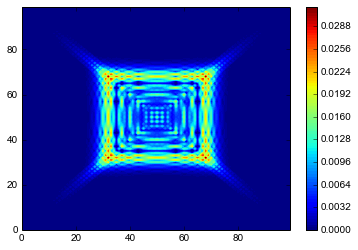

In [161]:
Z = zeros([100,100])
for i in range(100):
    for j in range(100):
        Z[i-50,j-50] = TwoD[i+100*j,100].real
contourf(range(100), range(0,100), abs(Z), 100)
colorbar()
figure()
Z = zeros([100,100])
for i in range(100):
    for j in range(100):
        Z[i-50,j-50] = TwoD[i+100*j,120].real
contourf(range(100), range(0,100), abs(Z), 100)
colorbar()
figure()
Z = zeros([100,100])
for i in range(100):
    for j in range(100):
        Z[i-50,j-50] = TwoD[i+100*j,150].real
contourf(range(100), range(0,100), abs(Z), 100)
colorbar()
figure()
Z = zeros([100,100])
for i in range(100):
    for j in range(100):
        Z[i-50,j-50] = TwoD[i+100*j,200].real
contourf(range(100), range(0,100), abs(Z), 100)
colorbar()

In [176]:
%%triqs -u gf
#include <triqs/gfs.hpp>
#include <triqs/gfs/bz.hpp>
#include <triqs/gfs/m_tail.hpp>

namespace h5 = triqs::h5;
using namespace triqs::gfs;
using namespace triqs::clef;
using namespace triqs::arrays;
using namespace triqs::lattice;
using triqs::utility::mindex;

array<std::complex<double>,2> f(double beta, double t, double mu) {

  auto bz = brillouin_zone{bravais_lattice{make_unit_matrix<double>(2)}};

  int n_freq = 1000;
  double t_min=-50, t_max = 50;

  int n_times = n_freq * 2 + 1;
  int L = 50;
  int n_bz = L;

  auto nf = [](double beta, auto eps_k) { return 1.0/(1.0+exp(beta*eps_k)); };
  auto mnf = [](double beta, auto eps_k) { return -(1.0-1.0/(1.0+exp(beta*eps_k))); };
  auto make_gxt = [&](auto func) {
    auto gxt = gf<cartesian_product<cyclic_lattice, retime>, matrix_valued, no_tail>{ {{L,L}, {t_min, t_max, n_times}}, {1, 1}};
    auto gkt = gf<cartesian_product<brillouin_zone, retime>, matrix_valued, no_tail>{ {{bz, n_bz}, {t_min, t_max, n_times}}, {1, 1}};
    
    placeholder<0> k_;
    placeholder<1> t_;

    auto eps_k = -2 * (cos(k_(0)) + cos(k_(1))) - mu;
    gkt(k_, t_) << exp(- 1_j * eps_k * t_) * func(beta,eps_k);
    auto gx_t = curry<1>(gxt);
    auto gk_t = curry<1>(gkt);
    gx_t[t_] << inverse_fourier(gk_t[t_]);
    return gxt;
  };

  auto g_lesser = make_gxt(nf);
  auto g_greater = make_gxt(mnf);

  auto y = 0;
  auto tp = t;
  array<std::complex<double>,2> a(50,50);
  for (int x=0; x<50; x++) {
    for (int k=0; k<50; k++) {
      double u = t*(k/50.0);
      a(x,k) = ( - g_greater(mindex(y-x,0,0),tp-u) * g_lesser(mindex(x,0,0),u-t)
                 + g_lesser(mindex(y-x,0,0),tp-u) * g_greater(mindex(x,0,0),u-t))(0,0);
      //a(x,k) = g_lesser(mindex(x,0,0),u-t)(0,0);
    }
  }

  return a;

}


(10, 40)

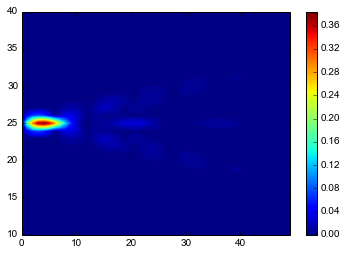

In [178]:
t = 5.0
Z = f(10.,t,0).imag
Zp = Z.copy()
for i in range(50):
    for j in range(50):
        Zp[i-25,-j] = Z[i,j]
contourf(range(50), range(0,50), abs(Zp), 100)
colorbar()
plt.ylim(10,40)

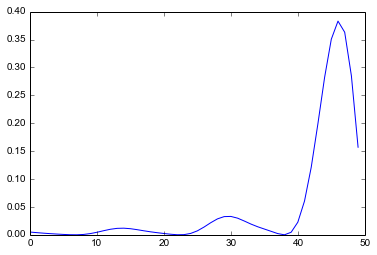

In [179]:
plot(arange(50),abs(f(100,5.0,0)[0,:].imag))